IMPORTING ALL NEEDED LIBRARIES -

In [34]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, f1_score,recall_score 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import nltk
from sklearn.model_selection import train_test_split, KFold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time



DATA SCRAPING -
1. Scraper class

In [18]:
class NewsScraper:
    def __init__(self,id_=0):
        self.id = id_
        self.total_collected = 0


  # write functions to scrape from other websites

    def total(self):
        print("Total articles collected: ", self.total_collected)

    def get_samaa_articles(self, max_pages=7):
        samaa_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://urdu.samaa.tv'
        categories = ['tech', 'lifestyle', 'sports', 'money', 'global']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1, max_pages + 1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}?page={page}"
                headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                }
                response = requests.get(url,headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # # Finding article cards
                # cards = soup.find('div', class_='row').find_all('div')  # Adjust class as per actual site structure
                # print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")
                article_container = soup.find('div', class_='story-columns')
                # if not article_container:
                #     print(f"\t--> No article container found on page {page} of '{category}'.")
                #     continue

                cards = article_container.find_all('div', class_='col-12 col-sm-4')
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='text')
                        # print("Here\n", div)

                        # Article Title
                        headline = div.find('a').get_text(strip=True).replace('\xa0', ' ')

                        # Article link
                        link = div.find('a')['href']

                        # Requesting the content from each article's link
                        headers = {
                        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                        }
                        article_response = requests.get(link,headers=headers)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='article-content').find_all('p')

                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )

                        # Storing data
                        samaa_df['id'].append(self.id)
                        samaa_df['title'].append(headline)
                        samaa_df['link'].append(link)
                        samaa_df['gold_label'].append(category.replace('lifestyle','entertainment').replace('global','world').replace('tech','science-technology').replace('money','business'))
                        samaa_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
                self.total_collected += success_count
            print('')
        # self.total_collected += success_count
        return pd.DataFrame(samaa_df)
    

    def get_express_articles(self, max_pages=7):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.express.pk'
        categories = ['saqafat', 'business', 'sports', 'science', 'world']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1, max_pages + 1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}/archives?page={page}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find('ul', class_='tedit-shortnews listing-page').find_all('li')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='horiz-news3-caption')

                        # Article Title
                        headline = div.find('a').get_text(strip=True).replace('\xa0', ' ')

                        # Article link
                        link = div.find('a')['href']

                        # Requesting the content from each article's link
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('span',class_='story-text').find_all('p')

                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    
    
    def get_dunya_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://urdu.dunyanews.tv/'
        categories = ['Business','Entertainment','Sports', 'World']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/index.php/ur/{category}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('div', class_='cNewsBox')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div', class_='col-md-8')

                        # Article Title
                        headline = div.find('h3').get_text(strip=True).replace('\xa0', ' ')
                        print(headline)
                        # Article link
                        link = div.find('a')['href']
                        link = f"https://urdu.dunyanews.tv{link}"
                        print(link)

                        # Requesting the content from each article's link
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='main-news col-md-12').find_all('p')
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    
    def get_24news_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.24urdu.com/'
        categories = ['business','entertainment','sports', 'world']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}"
                headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                }
                response = requests.get(url,headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('div', class_='col-md-6 col-xs-12 category-post-block')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='category-post-inner-div')

                        # Article Title
                        headline = div.find('h4').get_text(strip=True).replace('\xa0', ' ')
                        print(headline)
                        # Article link
                        link = div.find('a')['href']
                        print(link)

                        # Requesting the content from each article's link
                        headers = {
                        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                        }
                        article_response = requests.get(link,headers=headers)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='col-md-12 col-xs-12').find_all('p')
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    
    def get_neo_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.neonews.pk'
        categories = ['entertainment', 'international','sports','technology','business']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}"
                headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                }
                response = requests.get(url,headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('div', class_='col-md-6 col-sm-6 col-xs-12 widgetized w-1 rtl-right min_height_for_small_widget')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='title-heading')

                        # Article Title
                        headline = div.find('h3',class_='entry-title post-ur').get_text(strip=True).replace('\xa0', ' ')
                        print(headline)
                        # Article link
                        link = div.find('a')['href']
                        print(link)

                        # Requesting the content from each article's link
                        headers = {
                        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                        }
                        article_response = requests.get(link,headers=headers)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='entry-content clearfix news-detail-content').find_all('p')
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    
    def get_c42_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://www.city42.tv'
        categories = ['entertainment', 'sports','technology','business']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}"
                headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                }
                response = requests.get(url,headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('div', class_='col-md-6 col-xs-12')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='zm-post-header')

                        # Article Title
                        headline = div.find('h2',class_='zm-post-title').get_text(strip=True).replace('\xa0', ' ')
                        print(headline)
                        # Article link
                        link = div.find('a')['href']
                        print(link)

                        # Requesting the content from each article's link
                        headers = {
                        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                        }
                        article_response = requests.get(link,headers=headers)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='zm-post-content detail_page_content news-detail-content-class urdu_font block-content-ur').find_all('p')
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    def get_jhang_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://jang.com.pk/category/latest-news'
        categories = ['entertainment','sports', 'world', 'business', 'health-science']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find('ul', class_='scrollPaginationNew__').find_all('li')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='main-heading')

                        # Article Title
                        headline = div.find('a').get_text(strip=True).replace('\xa0', ' ')
                        #print(headline)
                        # Article link
                        link = div.find('a')['href']
                        #print(link)

                        # Requesting the content from each article's link
                        #print(link)
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='detail_view_content').find_all('p')
                        #print(paras)
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('science','health-science'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')

        return pd.DataFrame(express_df)
    
    def get_geo_articles(self):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://urdu.geo.tv/category'
        categories = ['business','entertainment','sports', 'world', 'science-technology']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}"
                response = requests.get(url)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.find_all('div', class_='col-xs-6 col-sm-6 col-lg-6 col-md-6 singleBlock')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('li',class_='border-box')

                        # Article Title
                        headline = div.find('div',class_= "entry-title").get_text(strip=True).replace('\xa0', ' ')
                        #print(headline)
                        # Article link
                        link = div.find('a')['href']
                        #print(link)

                        # Requesting the content from each article's link
                        article_response = requests.get(link)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")
                        #print(content_soup)
                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_='content-area').find_all('p')
                        #print(paras)
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if p.get_text(strip=True)
                        )
                        #print(combined_text)

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')

        return pd.DataFrame(express_df)




    def get_hum_articles(self, max_pages=7):
        express_df = {
            "id": [],
            "title": [],
            "link": [],
            "content": [],
            "gold_label": [],
        }
        base_url = 'https://humnews.pk'
        categories = ['lifestyle','world','sports','business','science-tech']   # saqafat is entertainment category

        # Iterating over the specified number of pages
        for category in categories:
            for page in range(2, max_pages + 1):
                print(f"Scraping page {page} of category '{category}'...")
                url = f"{base_url}/{category}/page/{page}/"
                headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                }

                response = requests.get(url,headers=headers)
                response.raise_for_status()
                soup = BeautifulSoup(response.text, "html.parser")

                # Finding article cards
                cards = soup.findAll('div', class_='archive-single-full')  # Adjust class as per actual site structure
                print(f"\t--> Found {len(cards)} articles on page {page} of '{category}'.")

                success_count = 0

                for card in cards:
                    try:
                        div = card.find('div',class_='archive-single-title')

                        # Article Title
                        headline = div.find('a')['title'].strip().replace('\xa0', ' ')

                        # Article link
                        link = div.find('a')['href']

                        # Requesting the content from each article's link
                        headers = {
                        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
                        }

                        article_response = requests.get(link,headers=headers)
                        article_response.raise_for_status()
                        content_soup = BeautifulSoup(article_response.text, "html.parser")


                        # Content arranged in paras inside <span> tags
                        paras = content_soup.find('div',class_="post-content-full test_fahad").find_all('p')
                        combined_text = " ".join(
                        p.get_text(strip=True).replace('\xa0', ' ').replace('\u200b', '')
                        for p in paras if ((p.get_text(strip=True)) and (p.find() == None))
                        )

                        # Storing data
                        express_df['id'].append(self.id)
                        express_df['title'].append(headline)
                        express_df['link'].append(link)
                        express_df['gold_label'].append(category.replace('saqafat','entertainment').replace('science','science-technology'))
                        express_df['content'].append(combined_text)

                        # Increment ID and success count
                        self.id += 1
                        success_count += 1

                    except Exception as e:
                        print(f"\t--> Failed to scrape an article on page {page} of '{category}': {e}")

                print(f"\t--> Successfully scraped {success_count} articles from page {page} of '{category}'.")
            print('')
        self.total_collected += success_count
        return pd.DataFrame(express_df)
    
    
    

2. Scraping 

In [20]:
scraper = NewsScraper()
#samaa_df = scraper.get_samaa_articles(7)
jhang_df = scraper.get_jhang_articles()
express_df = scraper.get_express_articles()
city42_df = scraper.get_c42_articles()
hum_df = scraper.get_hum_articles(14)
neo_df = scraper.get_neo_articles()
geo_df = scraper.get_geo_articles()
dunya_df = scraper.get_dunya_articles()
n24_df = scraper.get_24news_articles()
final_df = pd.concat([samaa_df,jhang_df,express_df,city42_df,hum_df,neo_df,geo_df,dunya_df,n24_df])
print(final_df["gold_label"].unique())
final_df["gold_label"] = final_df["gold_label"].str.lower()
final_df["gold_label"] = final_df["gold_label"].str.replace("science-technology-technology","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("science-technology-tech","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("health-health-science","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("science","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("science-technology-technology","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("technology","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("science-science-technology","science-technology")
final_df["gold_label"] = final_df["gold_label"].str.replace("international","world")
final_df["gold_label"] = final_df["gold_label"].str.replace("lifestyle","entertainment")
print(final_df["gold_label"].unique())
final_df.to_csv("final_data_ml.csv")

Scraping page 0 of category 'entertainment'...
	--> Found 102 articles on page 0 of 'entertainment'.
	--> Failed to scrape an article on page 0 of 'entertainment': 'NoneType' object has no attribute 'find'
	--> Failed to scrape an article on page 0 of 'entertainment': 'NoneType' object has no attribute 'find'
	--> Successfully scraped 100 articles from page 0 of 'entertainment'.

Scraping page 0 of category 'sports'...
	--> Found 102 articles on page 0 of 'sports'.
	--> Failed to scrape an article on page 0 of 'sports': 'NoneType' object has no attribute 'find'
	--> Failed to scrape an article on page 0 of 'sports': 'NoneType' object has no attribute 'find'
	--> Successfully scraped 100 articles from page 0 of 'sports'.

Scraping page 0 of category 'world'...
	--> Found 100 articles on page 0 of 'world'.
	--> Failed to scrape an article on page 0 of 'world': 'NoneType' object has no attribute 'find'
	--> Failed to scrape an article on page 0 of 'world': 'NoneType' object has no attribu

DATA CLEANING - 

In [35]:


def clean_and_save_data(file_path, output_path):
    
    data = pd.read_csv(file_path)
    data['content'] = data['content'].fillna('')

    data = data[data['content'].apply(len) > 0]

    def clean_text(text):
        return re.sub(r'[^\u0600-\u06FF\s]', '', text)

    data['title'] = data['title'].apply(clean_text)
    data['content'] = data['content'].apply(clean_text)

    label_mapping = {
        "entertainment": 0,
        "business": 1,
        "sports": 2,
        "science-technology": 3,
        "world": 4
    }
    data['gold_label_encoded'] = data['gold_label'].map(label_mapping)
    data.to_csv(output_path, index=False, encoding='utf-8-sig')

output_file_path = "cleaned_data_articles1.csv"
file_path="final_data_ml.csv"
clean_and_save_data(file_path, output_file_path)
print("Data cleaned succesfully!")



Data cleaned succesfully!


EXPLORATORY DATA ANALYSIS:
1. Printing data information -

In [36]:


data = pd.read_csv("cleaned_data_articles1.csv")

print(data.info())
print(data.head())

print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          2991 non-null   int64 
 1   id                  2991 non-null   int64 
 2   title               2991 non-null   object
 3   link                2991 non-null   object
 4   content             2991 non-null   object
 5   gold_label          2991 non-null   object
 6   gold_label_encoded  2991 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 163.7+ KB
None
   Unnamed: 0  id                                              title  \
0           0   0  پاکستانی حکام کو ہدف بنانے والی اینڈرائیڈ ایپس...   
1           1   1  سینیٹ کی قائمہ کمیٹی آئی ٹی کا اجلاس، انٹرنیٹ ...   
2           2   2  ملک بھر میں انٹرنیٹ کی سست روی کیوں؟ سما ء وجہ...   
3           3   3  ملک کے کئی شہروں میں تاحال انٹرنیٹ کی سست روی ...   
4           4   4  صرف  گھنٹوں کا ایک سال، ای

2. Examining class distribution - 

C:\Users\xylic\AppData\Local\Temp\ipykernel_27232\2006632392.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='gold_label', palette='viridis')


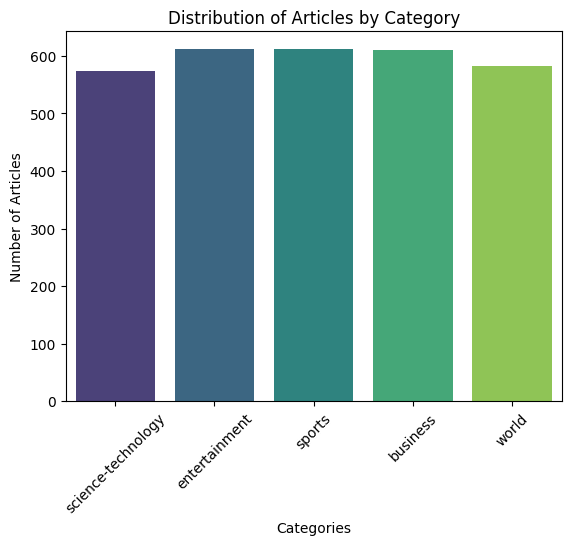

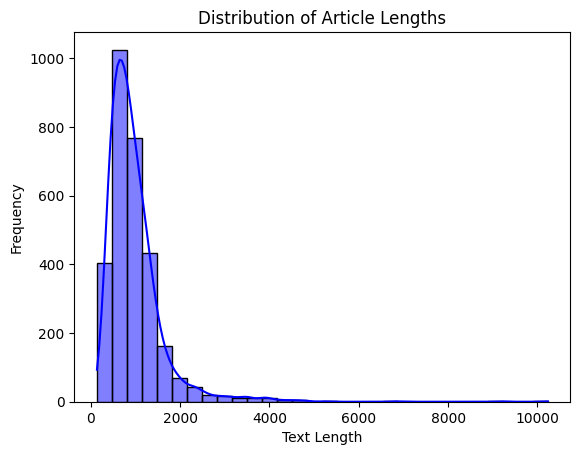

gold_label
business               762.968903
entertainment         1056.009804
science-technology    1111.357143
sports                 963.380719
world                  982.192440
Name: text_length, dtype: float64


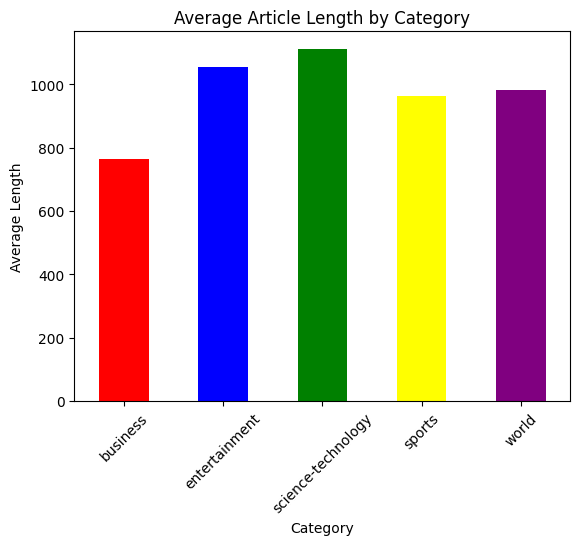

website
samaa        840
humnews      650
com          497
express      350
geo          300
city42       112
neonews       90
24urdu        80
dunyanews     72
Name: count, dtype: int64


C:\Users\xylic\AppData\Local\Temp\ipykernel_27232\2006632392.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=website_counts.index, y=website_counts.values, palette='tab10')


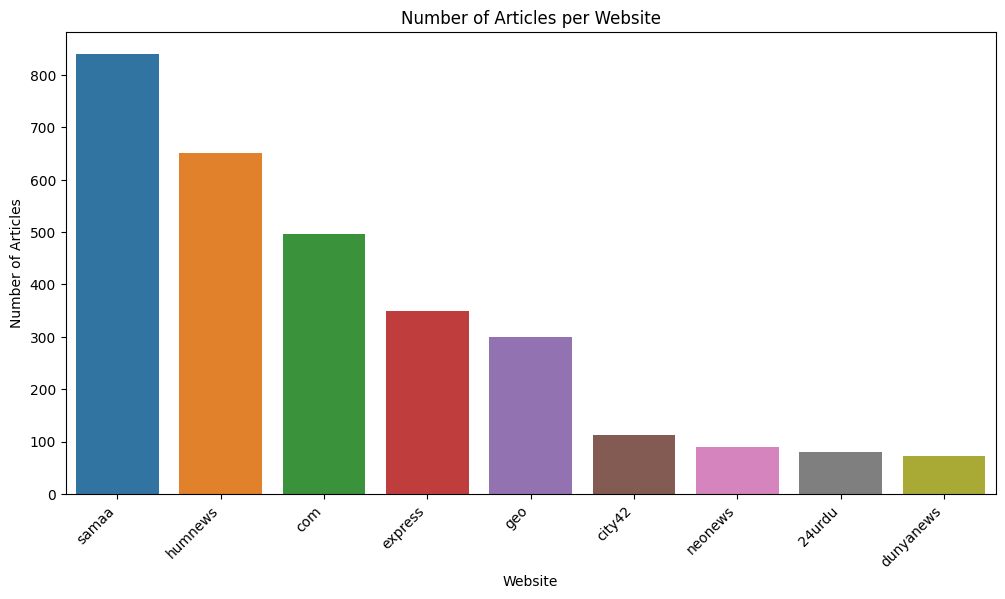

In [37]:



sns.countplot(data=data, x='gold_label', palette='viridis')
plt.title("Distribution of Articles by Category")
plt.xlabel("Categories")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.show()

data['text_length'] = data['content'].apply(len)

sns.histplot(data['text_length'], kde=True, bins=30, color='blue')
plt.title("Distribution of Article Lengths")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()
colors = ['red', 'blue', 'green','yellow','purple'] 
avg_length_per_category = data.groupby('gold_label')['text_length'].mean()
print(avg_length_per_category)

avg_length_per_category.plot(kind='bar', color = colors)
plt.title("Average Article Length by Category")
plt.xlabel("Category")
plt.ylabel("Average Length")
plt.xticks(rotation=45)
plt.show()




data['website'] = data['link'].apply(lambda x: urlparse(x).netloc.split('.')[-2] if pd.notnull(x) else 'Unknown')


website_counts = data['website'].value_counts()


print(website_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=website_counts.index, y=website_counts.values, palette='tab10')
plt.title("Number of Articles per Website")
plt.xlabel("Website")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45, ha='right')
plt.show()







3. Category Similarity Analysis using PCA -

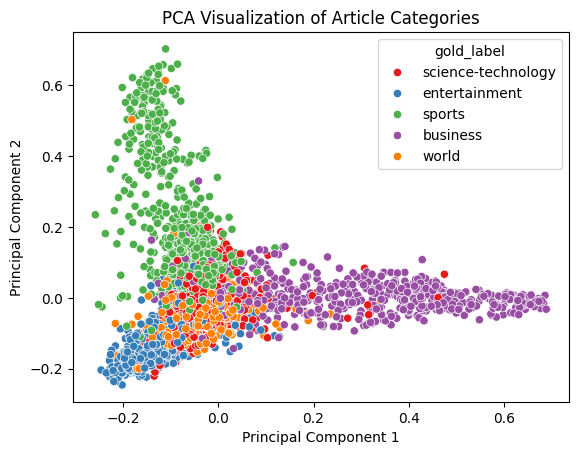

In [24]:



tfidf = TfidfVectorizer(max_features=1000)  
X_tfidf = tfidf.fit_transform(data['content'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['gold_label'] = data['gold_label']

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='gold_label', palette='Set1')
plt.title("PCA Visualization of Article Categories")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


Model 1 : MULTINOMIAL NAIVE BAYES

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\xylic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


(2936, 7)
(2936,)
(2936,)
Data shape after preprocessing: (2936, 7)
Train size: 2202, Test size: 734
(734,)
Initializing Naive Bayes model...
Training model...
Evaluating model...
Predicting on test data...
Prediction complete!

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96       164
         1.0       0.96      0.96      0.96       154
         2.0       0.98      0.99      0.98       150
         3.0       0.92      0.93      0.93       131
         4.0       0.90      0.89      0.89       135

    accuracy                           0.95       734
   macro avg       0.94      0.95      0.94       734
weighted avg       0.95      0.95      0.95       734

Final Accuracy: 94.69


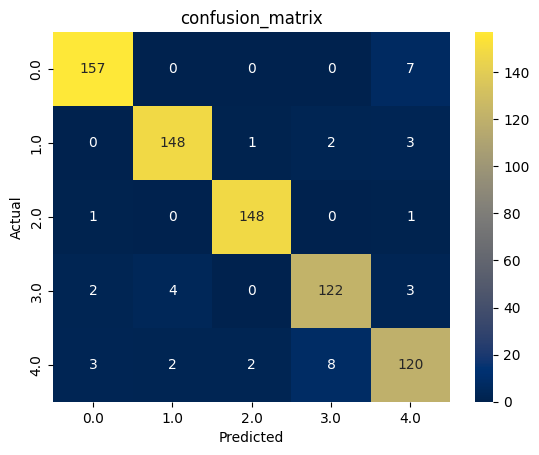

In [38]:
# code here
nltk.download('punkt_tab')



data = pd.read_csv("cleaned_data_articles1.csv")
data = data.drop_duplicates(subset="content")
data = data.drop_duplicates(subset="title")
print(data.shape)
print(data["content"].unique().shape)
print(data["title"].unique().shape)
data = data.dropna()
data["content"] = data["content"] + data["title"] + data["title"]
x_train,x_test ,y_train, y_test = train_test_split(data["content"].to_numpy(), data["gold_label_encoded"].to_numpy(),random_state=42)
print(f"Data shape after preprocessing: {data.shape}")
print(f"Train size: {x_train.shape[0]}, Test size: {x_test.shape[0]}")

print(y_test.shape)
class BagofWords:
    def __init__(self, input):
        self.vocabulary = {}
        self.counter = 0
        length = len(input)
        for i in range(length):
            #print(input[i])
            tokens = nltk.word_tokenize(input[i])
            for j in range(len(tokens)):
                if tokens[j] not in self.vocabulary.keys():
                    self.vocabulary[tokens[j]] = (self.counter, 1)
                    self.counter = self.counter + 1 
                else:
                   self.vocabulary[tokens[j]] =(self.vocabulary[tokens[j]][0], self.vocabulary[tokens[j]][1]+1)
        counter = 0
        for i in list(self.vocabulary.keys()):
            if self.vocabulary[i][1] > 1:
                self.vocabulary[i] = counter
                counter +=1
            else:
                del self.vocabulary[i]
  

    def vectorise(self,new_str):
        tokens = nltk.word_tokenize(new_str)
        ret = np.zeros(len(self.vocabulary.keys()))

        for i in range(len(tokens)):
            if tokens[i] in self.vocabulary.keys():
                ret[self.vocabulary[tokens[i]]] += 1
        return ret
    
#n_arr = np.unique(y_test)
#count = 0
#for i in n_arr:
    # print((y_test == i).sum(), (y_train == i).sum())
#    y_test[(y_test == i)] = count
#    y_train[(y_train == i)] = count
#    count = count + 1



class my_model:
    def __init__(self,x_train,y_train):
        print("Initializing Naive Bayes model...")
        self.mtweet_data_train = x_train
        self.mtweet_data_trainy = y_train
        self.bag = BagofWords(self.mtweet_data_train)
        self.training_array_tweet = np.empty((x_train.shape[0],2), dtype=object)     
        #self.data_columns = tweet_data_train.column_names
        self.classes_prior = {}
        self.clases_data = {}
        self.unique = [] 
    def train(self):
        print("Training model...")
        for i in range(len(self.mtweet_data_train)):
            self.training_array_tweet[i][0] = self.bag.vectorise(self.mtweet_data_train[i])
        for i in range(len(self.mtweet_data_trainy)):
            self.training_array_tweet[i][1] = self.mtweet_data_trainy[i]
        self.unique = np.unique(self.training_array_tweet[:,1])
        for i in self.unique:
            self.clases_data[i] = self.training_array_tweet[self.training_array_tweet[:,1] == i]
            self.classes_prior[i] = len(self.clases_data[i])/self.training_array_tweet.shape[0] 
            self.clases_data[i] = np.sum(self.clases_data[i], axis = 0) + 1
            self.clases_data[i] = np.log(self.clases_data[i][0]) - np.log(np.sum(self.clases_data[i][0]))
            #print(self.clases_data[i],i)
    def predict(self,input):
        print("Predicting on test data...")
        input_array = np.empty(len(input), dtype=object)
        for i in range(len(input)):
            input_array[i] = self.bag.vectorise(input[i])
        result = np.empty(len(input))
        options = np.empty(len(self.unique), dtype=object)
        for i in range(len(input_array)):
            count = 0
            for j in self.unique:
                options[count] = (np.sum(input_array[i] * self.clases_data[j] ) + np.log(self.classes_prior[j]),j)
                count = count  +1
        #print(options)
            result[i] = options[np.argmax(options)][1]
            #print(result[i])
        print("Prediction complete!\n")
        return result
Model_bayes1 = my_model(x_train,y_train)
Model_bayes1.train()
print("Evaluating model...")
result = Model_bayes1.predict(x_test)
y_test = y_test.astype(np.float64)
accuracy = accuracy_score(result, y_test)
# print(f'Accuracy: {accuracy*100:.4f}%')
# p1 = precision_score(result, y_test, average="macro")
# f1_p = f1_score(result, y_test, average="macro")
# rep = recall_score(result, y_test, average = "macro")
# print(f'Precision: {p1:.4f}')
# print(f'f1: {f1_p:.4f}')
# print(f'recall: {rep:.4f}')
print(classification_report(result, y_test))
print(f"Final Accuracy: {accuracy*100:.2f}")
cm1 = confusion_matrix(result, y_test)
sns.heatmap(cm1, annot=True, fmt="d", cmap="cividis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# dfn = pd.DataFrame(cm1)
# dfn.columns = n_arr
# dfn.index = n_arr
# sns.heatmap(dfn,annot=True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("confusion_matrix")
plt.show()

Model 2 : Support Vector Machine (SVM)

Cross-Validation Accuracy: 87.54%
Test Set Accuracy: 90.32%
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       137
           1       0.92      0.87      0.89       124
           2       0.86      0.98      0.91       115
           3       0.87      0.88      0.87       106
           4       0.95      0.81      0.88       117

    accuracy                           0.90       599
   macro avg       0.90      0.90      0.90       599
weighted avg       0.91      0.90      0.90       599



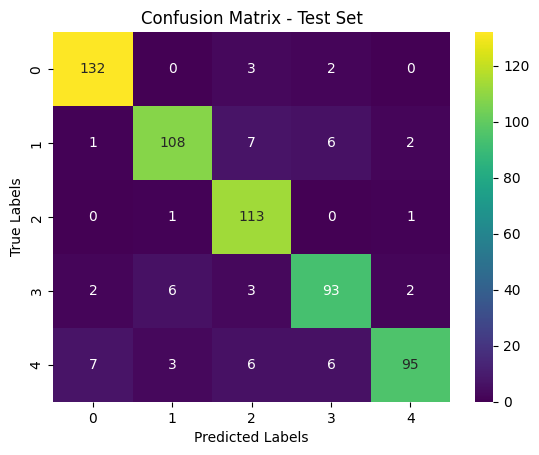

<Figure size 1000x800 with 0 Axes>

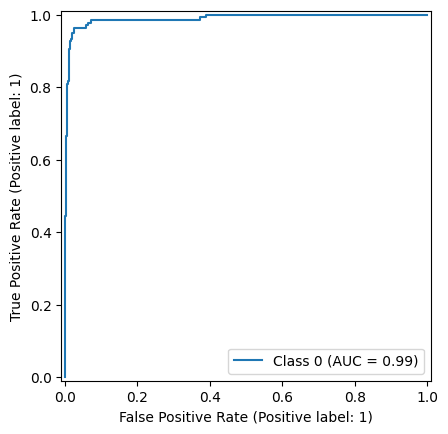

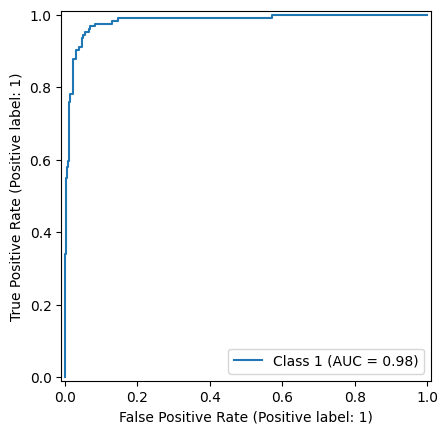

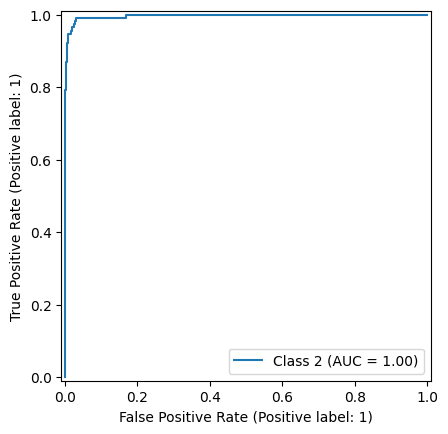

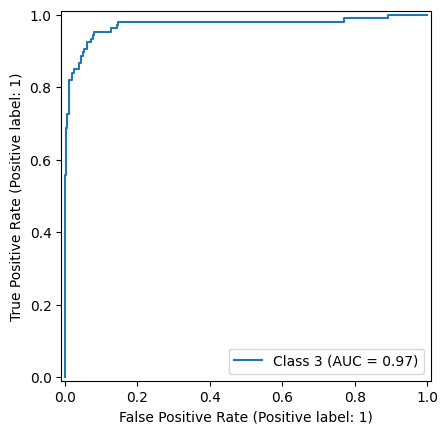

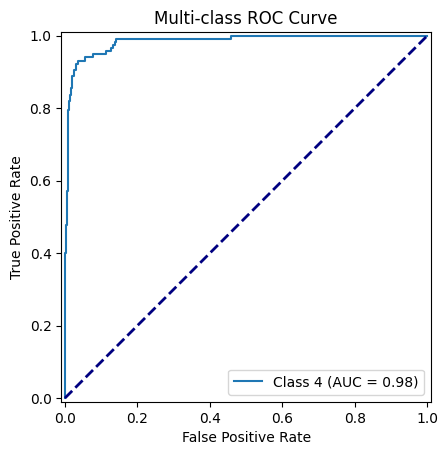

In [39]:


data = pd.read_csv("cleaned_data_articles1.csv")
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(data['content']).toarray()
y = data['gold_label_encoded']


class ManualSVM:
    def __init__(self, C=1.0, max_iter=1000, tolerance=1e-3):
        self.C = C
        self.max_iter = max_iter
        self.tolerance = tolerance

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.alpha = np.zeros(n_samples)
        self.b = 0
        self.w = np.zeros(n_features)

        self.kernel = np.dot(X, X.T)
        self.loss_history = []

        for iteration in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)

            for i in range(n_samples):
                E_i = self._decision_function(X[i]) - y[i]

                if not (y[i] * E_i < -self.tolerance and self.alpha[i] < self.C) and not (
                    y[i] * E_i > self.tolerance and self.alpha[i] > 0
                ):
                    continue

                j = np.random.choice([x for x in range(n_samples) if x != i])
                E_j = self._decision_function(X[j]) - y[j]

                alpha_i_old, alpha_j_old = self.alpha[i], self.alpha[j]

                if y[i] != y[j]:
                    L = max(0, self.alpha[j] - self.alpha[i])
                    H = min(self.C, self.C + self.alpha[j] - self.alpha[i])
                else:
                    L = max(0, self.alpha[j] + self.alpha[i] - self.C)
                    H = min(self.C, self.alpha[j] + self.alpha[i])

                if L == H:
                    continue

                eta = 2.0 * self.kernel[i, j] - self.kernel[i, i] - self.kernel[j, j]
                if eta >= 0:
                    continue

                self.alpha[j] -= y[j] * (E_i - E_j) / eta
                self.alpha[j] = np.clip(self.alpha[j], L, H)

                if abs(self.alpha[j] - alpha_j_old) < 1e-5:
                    continue

                self.alpha[i] += y[i] * y[j] * (alpha_j_old - self.alpha[j])

                b1 = (
                    self.b
                    - E_i
                    - y[i] * (self.alpha[i] - alpha_i_old) * self.kernel[i, i]
                    - y[j] * (self.alpha[j] - alpha_j_old) * self.kernel[i, j]
                )
                b2 = (
                    self.b
                    - E_j
                    - y[i] * (self.alpha[i] - alpha_i_old) * self.kernel[i, j]
                    - y[j] * (self.alpha[j] - alpha_j_old) * self.kernel[j, j]
                )

                if 0 < self.alpha[i] < self.C:
                    self.b = b1
                elif 0 < self.alpha[j] < self.C:
                    self.b = b2
                else:
                    self.b = (b1 + b2) / 2

            diff = np.linalg.norm(self.alpha - alpha_prev)
            if diff < self.tolerance:
                break

            margin = y * (np.dot(X, self.w) + self.b)
            hinge_loss = np.mean(np.maximum(0, 1 - margin))
            self.loss_history.append(hinge_loss)

        self.w = np.dot((self.alpha * y).T, X)

    def _decision_function(self, X):
        return np.dot(X, self.w) + self.b

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)



class MultiClassSVM:
    def __init__(self, C=2.0, max_iter=1000, tolerance=1e-3):
        self.C = C
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.models = {}

    def fit(self, X, y):
        self.classes = np.unique(y)

        for cls in self.classes:
            binary_y = np.where(y == cls, 1, -1)
            svm = ManualSVM(C=self.C, max_iter=self.max_iter, tolerance=self.tolerance)
            svm.fit(X, binary_y)
            self.models[cls] = svm

    def predict(self, X):
        predictions = np.zeros((X.shape[0], len(self.classes)))

        for i, cls in enumerate(self.classes):
            predictions[:, i] = self.models[cls]._decision_function(X)

        return self.classes[np.argmax(predictions, axis=1)]



def cross_validate_svm(X, y, n_splits=5):
    y = np.array(y)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    all_loss_history = [] 

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        multi_class_svm = MultiClassSVM(C=1.0, max_iter=5000)
        multi_class_svm.fit(X_train_fold, y_train_fold)

        y_val_pred = multi_class_svm.predict(X_val_fold)
        accuracies.append(accuracy_score(y_val_fold, y_val_pred))

        fold_losses = [model.loss_history for model in multi_class_svm.models.values()]
        all_loss_history.append(fold_losses)

    print(f"Cross-Validation Accuracy: {np.mean(accuracies) * 100:.2f}%")

    return all_loss_history, accuracies



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

all_loss_history, accuracies = cross_validate_svm(X_train, y_train, n_splits=5)


max_len = max(len(loss) for fold_losses in all_loss_history for loss in fold_losses)  


padded_loss_history = []
for fold_losses in all_loss_history:
    padded_fold_losses = [np.pad(loss, (0, max_len - len(loss)), constant_values=np.nan) for loss in fold_losses]
    padded_loss_history.append(padded_fold_losses)



multi_class_svm = MultiClassSVM(C=1.0, max_iter=5000)
multi_class_svm.fit(X_train, y_train)
y_test_pred = multi_class_svm.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Set Accuracy: {test_accuracy * 100:.2f}%")


print(classification_report(y_test, y_test_pred))

cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()




y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]


decision_scores = np.zeros((X_test.shape[0], n_classes))
for i, cls in enumerate(multi_class_svm.classes):
    decision_scores[:, i] = multi_class_svm.models[cls]._decision_function(X_test)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    RocCurveDisplay.from_predictions(
        y_test_binarized[:, i], decision_scores[:, i], name=f"Class {i}"
    )

plt.plot([0, 1], [0, 1], color="navy", linestyle="--", lw=2)  
plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()



Model 3 : Neural Network -

Training starts...
Training complete. Testing starts...
Final Accuracy: 0.94

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       137
           1       0.94      0.90      0.92       124
           2       0.99      0.94      0.96       115
           3       0.84      0.93      0.88       106
           4       0.93      0.95      0.94       117

    accuracy                           0.94       599
   macro avg       0.94      0.94      0.94       599
weighted avg       0.94      0.94      0.94       599



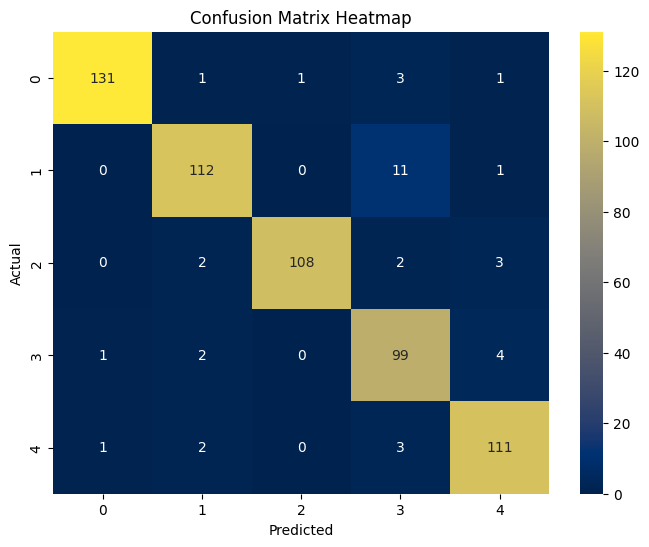

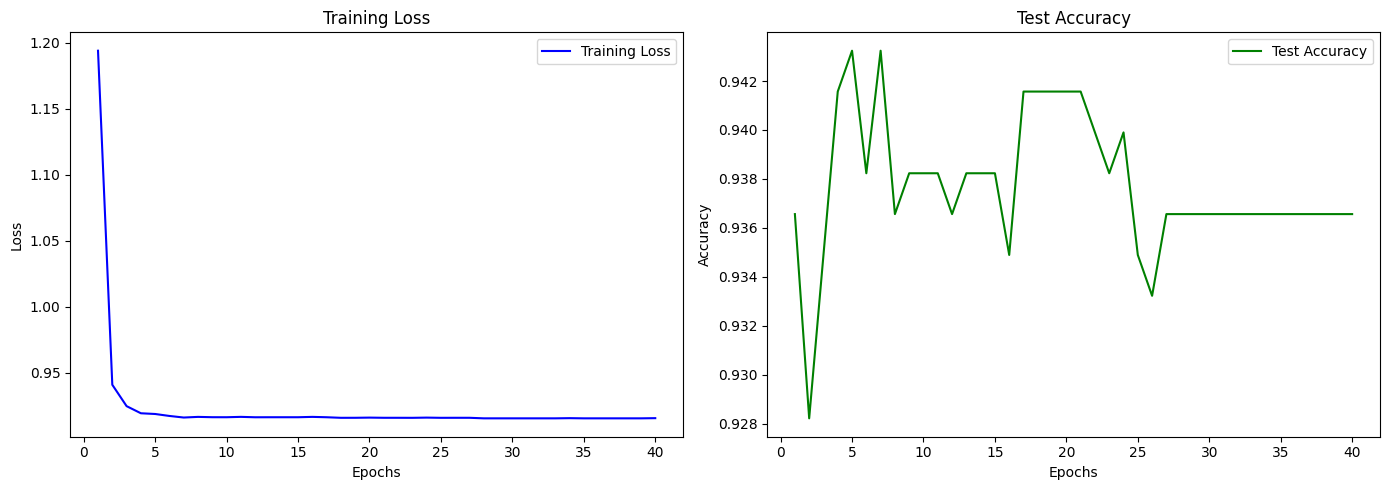

In [40]:



file_path = "cleaned_data_articles1.csv"
data = pd.read_csv(file_path)


tfidf_content = TfidfVectorizer(max_features=3000)
tfidf_title = TfidfVectorizer(max_features=1000)

X_content = tfidf_content.fit_transform(data['content']).toarray()
X_title = tfidf_title.fit_transform(data['title']).toarray()

X_combined = np.hstack((X_content, X_title))
scaler = MinMaxScaler()
X_combined_normalized = scaler.fit_transform(X_combined)

y = data['gold_label_encoded'].to_numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X_combined_normalized, y, test_size=0.2, random_state=42
)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)  
        )
    
    def forward(self, x):
        return self.model(x)

input_size = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = NeuralNetwork(input_size, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 40
train_losses = []
test_accuracies = []

print("Training starts...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    test_accuracies.append(correct / total)

print("Training complete. Testing starts...")

model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

accuracy = sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
print(f"Final Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='cividis', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
